# Redes Generativas Adversariales de Convolución Profunda (DCGANs - Deep Convolutional Generative Adversarial Networks)

Básicamente son iguales a las GAN.  Sin embargo, se ha visto que para imágenes es mejor trabajar con Redes Convolucionales.  Por esto tiene sentido adaptar las unidades de las GAN (Generador y Discriminador) para que trabajen con Redes Convolucionales.

OJO!!!  Aún con este ejercicio simple, puede que una PC ya no rinda bien por lo que sería mejor usar algo como Google Colab.  El código en este NB tiene habilitado el código para trabajar con Google Colab.  Se ha incluido, como comentarios, el código para trabajar con las PCs, si se quiere hacer así, se debe poner en comentarios las instrucciones específicas para Google Colab y quitar el "hash tag" de las instrucciones normales.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.datasets import mnist

In [ ]:
(X_entreno, y_entreno), (X_prueba, y_prueba) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


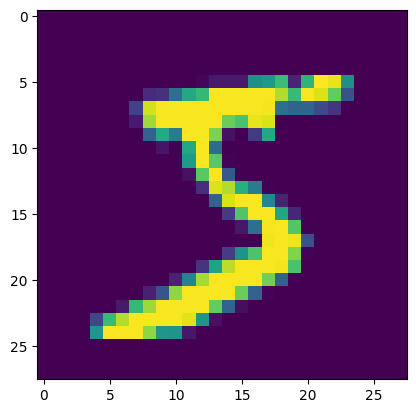

In [ ]:
plt.imshow(X_entreno[0])

In [ ]:
y_entreno

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

## Cambiar la forma y la escala (normailizar) de las imágenes para DCGAN (Deep Convolutional GAN)

El Generador utilizará la función de activación tanh() para la última capa.  Por este motivo debe cambiarse X_entreno para que los valores estén en el rango de -1 a 1.

In [ ]:
X_entreno = X_entreno/255

In [ ]:
X_entreno.shape

(60000, 28, 28)

In [ ]:
X_entreno = X_entreno.reshape(-1, 28, 28, 1) * 2. - 1.

In [ ]:
X_entreno.shape

(60000, 28, 28, 1)

In [ ]:
X_entreno.min()

-1.0

In [ ]:
X_entreno.max()

1.0

## Para que el tiempo de entrenamiento sea menor, vamos a filtrar los datos parar solo tener de un mismo dígito

In [ ]:
n = 0
X_filtrado = X_entreno

In [ ]:
X_filtrado.shape

(60000, 28, 28, 1)

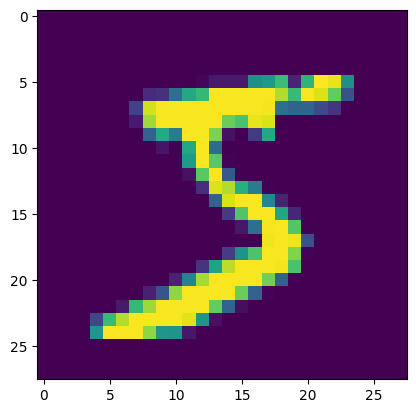

In [ ]:
#En Jupyter NB funciona esto para ver una imagen
n = 0
plt.imshow(X_filtrado[n])

In [ ]:
# Para que funcione en Google Colab
#n = 0
#plt.imshow(X_filtrado.reshape(5923, 28, 28)[n])

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Dropout, LeakyReLU, Flatten, BatchNormalization, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential

## Creación del GAN

### Empezar con el generador

El generador es una especie de "decodificador", haciendo referencia al AutoCodificador que ya vimos. Lo primero que hay que hacer es determinar un tamaño de codificación, o dimensión, que recibirá y que luego ampliará al tamaño de las imágenes en cuestión. Este número lo seleccionamos nosotros. Debe ser sustancialmente menor a las imágenes, pero no tan pequeño que se pueda perder alguna información importante.

Nótese que una ventaja de usar Convolución es que permite aprovechar la naturaleza 2D de las imágenes.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

# Tamaño de la capa que va hacia el
#    Generador
tamanio_codificacion = 100

In [ ]:
generador = Sequential()
generador.add(Dense(7 * 7 * 128,
                    input_shape = [tamanio_codificacion]))
generador.add(Reshape([7, 7, 128]))
generador.add(BatchNormalization())
generador.add(Conv2DTranspose(64,
                              kernel_size = 5,
                              strides = 2,
                              padding = "same",
                              activation = "relu"))
generador.add(BatchNormalization())
generador.add(Conv2DTranspose(1,
                              kernel_size = 5,
                              strides = 2,
                              padding = "same",
                              activation = "tanh"))



### Ahora a definir el discriminador

In [ ]:
discriminador = Sequential()
discriminador.add(Conv2D(64,
                         kernel_size = 5,
                         strides = 2,
                         padding = "same",
                         activation = LeakyReLU(0.3),
                         input_shape = [28, 28, 1]))
discriminador.add(Dropout(0.5))
discriminador.add(Conv2D(128,
                         kernel_size = 5,
                         strides = 2,
                         padding = "same",
                         activation = LeakyReLU(0.3)))
discriminador.add(Dropout(0.5))
discriminador.add(Flatten())
discriminador.add(Dense(1,
                        activation = "sigmoid"))

In [ ]:
GAN = Sequential([generador, discriminador])

In [ ]:
discriminador.compile(loss="binary_crossentropy", optimizer="adam")
discriminador.trainable = False

Nótese que el discriminador se compila, pero el generador no. En vez, se crea el GAN y se compila la red completa para que el generador se entrene únicamente a través del GAN completo.

También, como se mencionó en la intuición, el discriminador no será entrenado durante la segunda fase

Finalmente, la red GAN también tiene solo como salida un resultado binario

Las siguientes líneas obedecen a estas observaciones

In [ ]:
GAN.compile(loss = "binary_crossentropy",
            optimizer = "adam")

Ver un resúmen de lo hecho

In [ ]:
GAN.layers

In [ ]:
GAN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 1)         840705    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1053570 (4.02 MB)
Trainable params: 840321 (3.21 MB)
Non-trainable params: 213249 (833.00 KB)
_________________________________________________________________


In [ ]:
GAN.layers[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 128)         512       
 Normalization)                                                  
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        204864    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                        

In [ ]:
GAN.layers[1].summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 212865 (831.50 KB)
Trainable params: 0 (

### Configurar las tandas para entrenamiento

In [ ]:
import tensorflow as tf

In [ ]:
# Si se desea que el entrenamiento sea más
#   rápido, se puede tomar un valor mayor
tamanio_tanda = 32

https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle

El tamaño del "buffer" en el Conjunto_Datos.shuffle() puede afectar la aleatoridad de conjunto de datos, y por lo tanto el orden en los cuales aparecen los elementos.

In [ ]:
# mis_datos = X_entreno
mis_datos = X_filtrado

In [ ]:
datos = tf.data.Dataset.from_tensor_slices(mis_datos).shuffle(buffer_size = 1000)

In [ ]:
type(datos)

tensorflow.python.data.ops.shuffle_op._ShuffleDataset

In [ ]:
datos = datos.batch(tamanio_tanda,
                    drop_remainder = True).prefetch(1)

In [ ]:
# Hay muchas mas capas y es mejor dar más
#   tiempo para entrenar...por eso puede
#   ser necesario trabajar con GPUs
epocas = 20

**NOTA: el generador nunca vé imágenes verdaderas.  Aprende viendo las gradientes que fluyen hacia atrás en el discriminador.  Entre mejor se va poniendo el discriminador a través del entrenamiento, más información está contenida en sus gradientes. Esto hace que el generador vaya progresando en su aprendizaje sobre cómo generar imágenes falsas, en este caso, ceros falsificados.**


## Iteración de Entrenamiento

Normalmente se usa el .fit() para entrenar.  Sin embargo como acá se tienen dos redes en competencia (adversariales), se creará una iteración de entrenamiento

In [ ]:
# Tomar los componentes por separado
generador, discriminador = GAN.layers

In [ ]:
for epoca in range(epocas):
    print(f"Voy por la época {epoca + 1}")
    i = 0
    # Para cada tanda en el conjunto de datos
    for X_tanda in datos:
        i = i + 1
        if i % 25 == 0:
            print(f"\tVoy por la tanda número {i} de {len(mis_datos) // tamanio_tanda}")

        ##############################################
        ## Fase 1 - Entrenamiento del DISCRIMINADOR ##
        ##############################################

        # Crear Ruido
        ruido = tf.random.normal(shape = [tamanio_tanda,
                                          tamanio_codificacion])

        # Generar imágenes falsas (números) basadas sólo en una entrada de ruido
        # Notar que el Generador nunca vé imágenes reales (solo ruido)
        imagenes_gen = generador(ruido)

        # Concatenar las Imágenes Generadas con las Verdaderas
        # Para poder utilizar tf.concat, los tipos de los datos deben
        #    coincidir!
        X_falso_vs_real = tf.concat([imagenes_gen,
                                     tf.dtypes.cast(X_tanda,
                                                    tf.float32)],
                                    axis = 0)

        # Las metas se fijan en cero (0) para imágenes falsas
        #     y uno (1) para imágenes reales
        y1 = tf.constant([[0.]] * tamanio_tanda + [[1.]] * tamanio_tanda)

        # La siguiente instrucción obvia una advertencia de Keras
        discriminador.trainable = True

        # Entrenar al discriminador con esta tanda
        discriminador.train_on_batch(X_falso_vs_real, y1)


        ##########################################
        ## Fase 2 - Entrenamiento del GENERADOR ##
        ##########################################

        # Crear algo de ruido
        ruido = tf.random.normal(shape=[tamanio_tanda,
                                        tamanio_codificacion])

        # Se quiere que el discriminador crea
        #   que las imágenes falas son reales
        y2 = tf.constant([[1.]] * tamanio_tanda)

        # Evitar una advertencia
        discriminador.trainable = False

        GAN.train_on_batch(ruido, y2)

print("Entrenamiento Completado")

Voy por la época 1
	Voy por la tanda número 25 de 1875
	Voy por la tanda número 50 de 1875
	Voy por la tanda número 75 de 1875
	Voy por la tanda número 100 de 1875
	Voy por la tanda número 125 de 1875
	Voy por la tanda número 150 de 1875
	Voy por la tanda número 175 de 1875
	Voy por la tanda número 200 de 1875
	Voy por la tanda número 225 de 1875
	Voy por la tanda número 250 de 1875
	Voy por la tanda número 275 de 1875
	Voy por la tanda número 300 de 1875
	Voy por la tanda número 325 de 1875
	Voy por la tanda número 350 de 1875
	Voy por la tanda número 375 de 1875
	Voy por la tanda número 400 de 1875
	Voy por la tanda número 425 de 1875
	Voy por la tanda número 450 de 1875
	Voy por la tanda número 475 de 1875
	Voy por la tanda número 500 de 1875
	Voy por la tanda número 525 de 1875
	Voy por la tanda número 550 de 1875
	Voy por la tanda número 575 de 1875
	Voy por la tanda número 600 de 1875
	Voy por la tanda número 625 de 1875
	Voy por la tanda número 650 de 1875
	Voy por la tanda núme

**Ahora que está todo entrenado, se puede probar solo el generador para producir imágenes**

In [ ]:
ruido = tf.random.normal(shape = [10, tamanio_codificacion])

In [ ]:
ruido.shape

In [ ]:
plt.imshow(ruido)

In [ ]:
imagenes = generador(ruido)


**Utilice esta sección para trabajar con Jupyter NB**

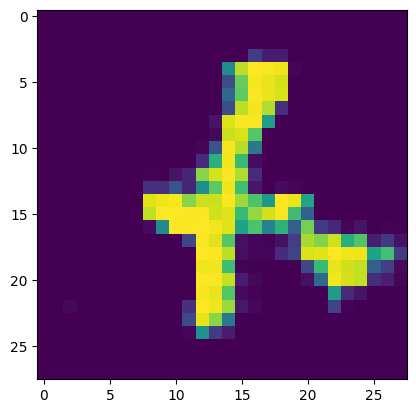

In [ ]:
plt.imshow(imagenes[0])

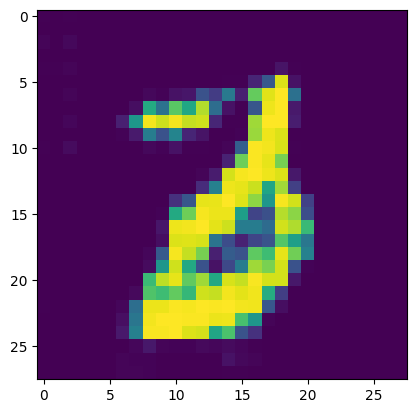

In [ ]:
plt.imshow(imagenes[3])

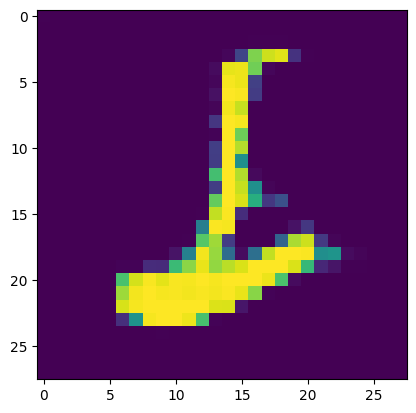

In [ ]:
plt.imshow(imagenes[6])

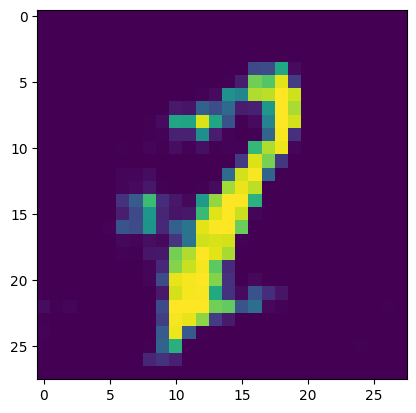

In [ ]:
plt.imshow(imagenes[9])

**Utilice esta sección para trabajar con Google Colab**

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

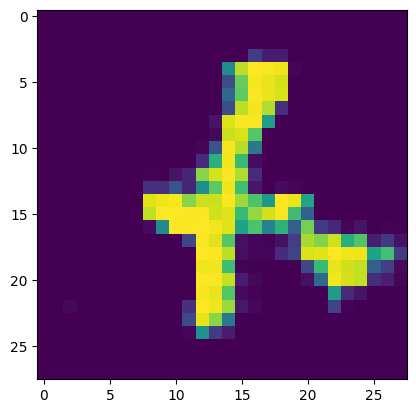

In [ ]:
n = 0
plt.imshow(imagenes[n].reshape(28, 28))

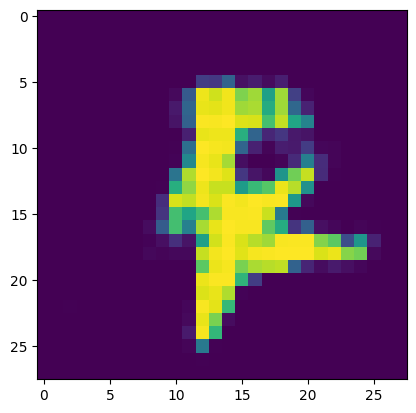

In [ ]:
n = 1
plt.imshow(imagenes[n].reshape(28, 28))

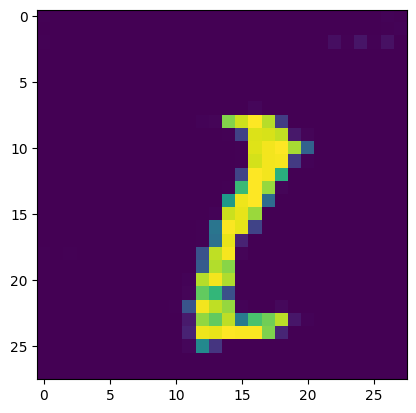

In [ ]:
n = 2
plt.imshow(imagenes[n].reshape(28, 28))

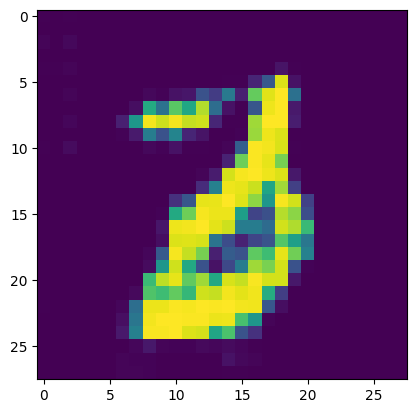

In [ ]:
n = 3
plt.imshow(imagenes[n].reshape(28, 28))

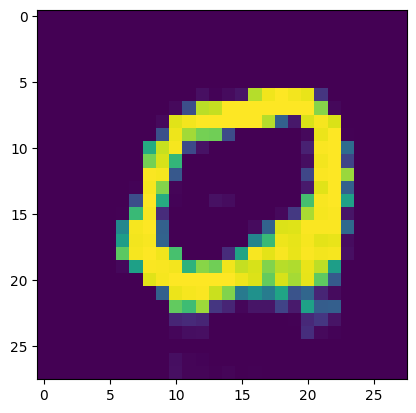

In [ ]:
n = 4
plt.imshow(imagenes[n].reshape(28, 28))

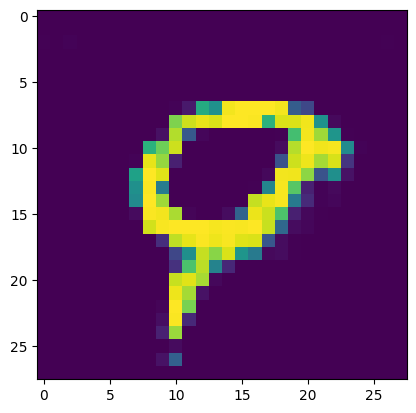

In [ ]:
n = 5
plt.imshow(imagenes[n].reshape(28, 28))

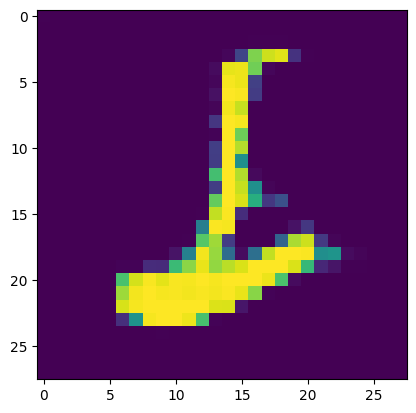

In [ ]:
n = 6
plt.imshow(imagenes[n].reshape(28, 28))

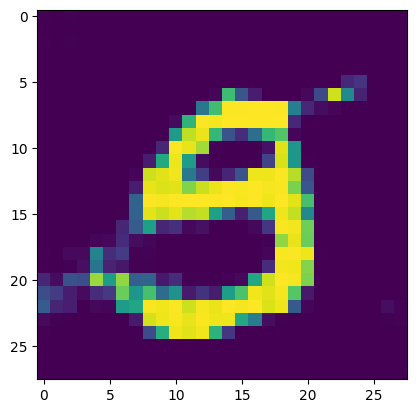

In [ ]:
n = 7
plt.imshow(imagenes[n].reshape(28, 28))

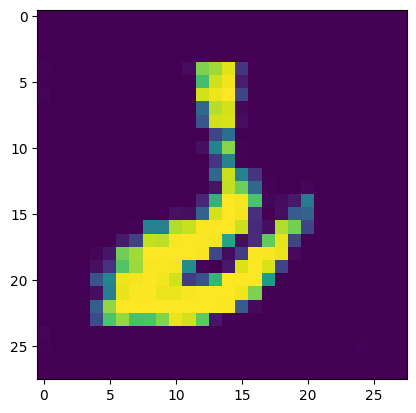

In [ ]:
n = 8
plt.imshow(imagenes[n].reshape(28, 28))

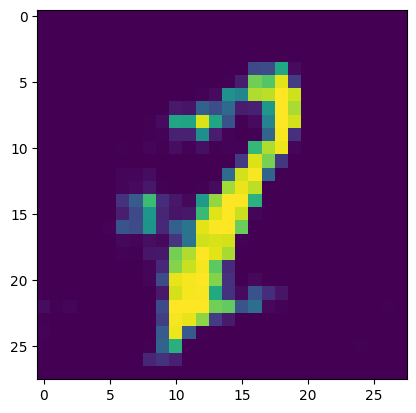

In [ ]:
n = 9
plt.imshow(imagenes[n].reshape(28, 28))

**Ahora las 10 imágenes tienen mejor apariencia y todas son diferentes.**

**En este campo, este es el  estado-del-arte!  Para obtener resultados más realistas, se requieren GPUs de mucha potencia y "jugar" bastante con los hiper-parámetros!**